# **Project 4** 
Elda Pipa - S3890821 \\
Bastiaan Nijman - S3465039 \\
Gina Biddlecombe - S3893138 \\
Teddy Milkova - S4105923 \\

**Python**

We chose to do this project in python, all four of us have more experience in it and feel more comfortable using python over mathematica. The libraries already in python are also very useful especially for machine learning.

**The Research**

In this assignment we look at pre-processed data produced by an electromagnetic calorimeter (EMC). This EMC measures the scattering angles and the energy of photons originating from an antiproton-proton interaction point. One of the background sources stems from neutrons, also being electrically neutral. The data consists of varying features(listed in the original assignment document) measured by the EMC for the photons/neutrons. First we try to visualize the data, then we look at which features are the best at seperating the photons/neutrons. Then using machine learning techniques we try to seperate the photons from the neutrons, here we try to maximize the figure of merit(FOM).





**Importing relevant libraries:**

In [1]:
# basic imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# to access data from URL
import requests                                      
from requests.auth import HTTPBasicAuth      
from six import StringIO         

# classifiers
from sklearn import tree     
from sklearn import neighbors                        
from sklearn.ensemble import RandomForestClassifier 
from sklearn.neural_network import MLPClassifier  
from random import uniform as random_uniform     
from sklearn import cluster

# for the correlation matrix
import seaborn as sn  

# for plotting decision tree diagrams
from IPython.core.display import Image               
from six import StringIO                             
import re          

# for optimisation
from scipy.optimize import minimize

# for creating combinations of features
from itertools import combinations as cmb

**Importing the data:**

In [2]:
# photon data
url="https://jgmes.home.xs4all.nl/emc_gam.txt"
s=requests.get(url).content
gam_data = pd.read_csv(StringIO(s.decode('utf-8')))

# neutron data
url="https://jgmes.home.xs4all.nl/emc_neutron.txt"
s=requests.get(url).content
neut_data = pd.read_csv(StringIO(s.decode('utf-8')))

# id = 1 -> photon (gamma)
# id = 2 -> neutron
index_gam = [1 for x in range(len(gam_data))]
intex_neut = [2 for x in range(len(neut_data))]

gam_data['id'] = index_gam
neut_data['id'] = intex_neut

# create a single dataFrame with all of the data
data = gam_data.append(neut_data)
data.head(5)

,Th,Ph,E,NrHits,NrBumps,E1,E1E9,E9E25,Z20,Z53,LatMom,id
0,50.8457,-0.008022,1.67371,19,1,1.05547,0.667862,0.960176,0.970492,0.003752,0.372940,1
1,22.9273,-119.515000,4.69804,19,1,2.90849,0.641230,0.975758,0.978056,0.000140,0.674813,1
2,130.3010,-126.725000,2.77313,17,1,1.82686,0.680077,0.976782,0.974232,0.003527,0.303936,1
3,160.2830,59.330500,3.09939,20,1,2.17111,0.735619,0.967568,0.970230,0.000979,0.690777,1
4,89.4000,-15.521300,3.19431,21,1,2.40089,0.774224,0.978969,0.974945,0.000703,0.882015,1


**Normalising the Data:**

In [3]:
# function that normalises the data (adapted from 20201019_JGM_CMST.ipynb by J.G. Messchendorp)
def normaliseData(dataSet, featureList):
  '''
  Function that calculates the normalised values for a list of features and appends them as additional columns in the data. 

  Returns the updated dataFrame and a list of all normalised features.
  '''
  dataTemp = dataSet.copy()
  featuresNorm = []

  # create a column in dataset with normalised values for all features in featureList
  for feature in featureList:
    featureNew = feature + 'Norm'
    featuresNorm.append(featureNew)
    dataTemp[featureNew] = (dataTemp[feature] - dataTemp[feature].mean()) / dataTemp[feature].std()
  
  return dataTemp, featuresNorm

In [4]:
# list of numerical features in dataFrame
featuresNum = ['Th', 'Ph', 'E',	'NrHits',	'NrBumps', 'E1', 'E1E9',	'E9E25', 'Z20',	'Z53',	'LatMom']

# normalise the dataset and get list of normalised features
data, featuresNorm = normaliseData(data, featuresNum)

In [5]:
# check normalisation
data.describe()

,Th,Ph,E,NrHits,NrBumps,E1,E1E9,E9E25,Z20,Z53,LatMom,id,ThNorm,PhNorm,ENorm,NrHitsNorm,NrBumpsNorm,E1Norm,E1E9Norm,E9E25Norm,Z20Norm,Z53Norm,LatMomNorm
count,86872.000000,86872.000000,86872.000000,86872.000000,86872.000000,86872.000000,86872.000000,86872.000000,86872.000000,86872.000000,86872.000000,86872.000000,8.687200e+04,8.687200e+04,8.687200e+04,8.687200e+04,8.687200e+04,8.687200e+04,8.687200e+04,8.687200e+04,8.687200e+04,8.687200e+04,8.687200e+04
mean,79.685466,0.148227,1.829305,16.831706,1.072451,1.153162,0.664703,0.928475,0.888439,0.018732,0.626277,1.500875,3.164252e-15,-2.145249e-17,-2.560736e-15,-5.172807e-14,-7.274422e-14,-7.853830e-15,3.183640e-14,9.997333e-15,4.785270e-14,2.988430e-15,2.100309e-14
std,47.000290,103.991860,1.403104,7.612113,0.295819,1.044867,0.167809,0.083713,0.168847,0.043395,0.297361,0.500002,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,0.499105,-180.001000,0.024076,1.000000,1.000000,0.006992,0.171400,0.356098,0.000000,0.000000,0.000000,1.000000,-1.684806e+00,-1.732340e+00,-1.286597e+00,-2.079805e+00,-2.449180e-01,-1.096953e+00,-2.939660e+00,-6.837385e+00,-5.261811e+00,-4.316605e-01,-2.106116e+00
25%,38.653650,-89.965025,0.649015,11.000000,1.000000,0.294016,0.530591,0.908604,0.874595,0.001861,0.334035,1.000000,-8.730120e-01,-8.665414e-01,-8.411998e-01,-7.661088e-01,-2.449180e-01,-8.222542e-01,-7.991873e-01,-2.373639e-01,-8.198620e-02,-3.887732e-01,-9.827855e-01
50%,77.745400,0.708017,1.389615,17.000000,1.000000,0.738280,0.678145,0.962716,0.960193,0.004184,0.679864,2.000000,-4.127774e-02,5.383018e-03,-3.133699e-01,2.210866e-02,-2.449180e-01,-3.970665e-01,8.010463e-02,4.090304e-01,4.249652e-01,-3.352453e-01,1.802094e-01
75%,119.245000,89.746075,2.896270,22.000000,1.000000,1.880318,0.804436,0.976549,0.974134,0.016598,0.923037,2.000000,8.416870e-01,8.615852e-01,7.604318e-01,6.789565e-01,-2.449180e-01,6.959312e-01,8.326903e-01,5.742739e-01,5.075343e-01,-4.918080e-02,9.979782e-01
max,178.647000,180.000000,5.234740,60.000000,6.000000,4.369720,1.000000,1.000000,1.000000,0.779841,0.999937,2.000000,2.105552e+00,1.729479e+00,2.427073e+00,5.671000e+00,1.665730e+01,3.078438e+00,1.998084e+00,8.544101e-01,6.607266e-01,1.753927e+01,1.256588e+00


**General Classifier Method for Supervised Machine Learning:**

In [6]:
# function that implements various classifiers for supervised ML (adapted from 20201019_JGM_CMST.ipynb by J.G. Messchendorp)
def classifySupervised (classifier, data, params,
             testProportion=0.5, featureList=featuresNorm, 
             plotTree=False):
    """
    Function that applies a specific classifier to 'data' using the features 'featureList'.
    'testProportion' is the fraction of the data to be used as a test sample (default = 0.5). 
    The function returns 'data' with additional columns 'isTrain' and 'prediction'.
    
    The following machine learning classifiers can be called in this method:
      {"AB" -> classifier}
      {[ , ] -> params}

    "DT": decision tree         [minimum impurity decrease, max depth]
    "RF": random forest         [number of estimators, minimum impurity decrease]
    "kNN": k nearest neighbours [number of neighbours]    
    "MLP": neural network(MLP)  [hidden layer sizes]   
    """
    
    # ensure that testProportion value is valid
    assert 0<testProportion<1
     
    # create a temp dataset to work with
    dataTemp = data.copy()
    
    # split data into training and test data using test proportion
    dataTemp['isTrain'] = np.random.uniform(0, 1, len(dataTemp)) <= (1-testProportion)
    trainData, testData = dataTemp[dataTemp['isTrain']==True].copy(), dataTemp[dataTemp['isTrain']==False].copy()

    # Decision Tree Classifier
    if   (classifier=="DT"):
        clf = tree.DecisionTreeClassifier(criterion='entropy',min_impurity_decrease=params[0], max_depth=params[1])
    # Random Forest Classifier
    elif (classifier=="RF"):
        clf = RandomForestClassifier(n_estimators=params[0], max_features=params[1])
    # kNN Classifier
    elif (classifier=="kNN"):
        clf = neighbors.KNeighborsClassifier(n_neighbors=params[0])
    # MLP Classifier
    elif (classifier=="MLP"):
        clf = MLPClassifier(solver='lbfgs', max_iter=5000, hidden_layer_sizes=params[0])
    else:
        print("<E> Classifier not implemented: ", classifier)
        return None
    
    # fit the data with the classifier (train based on id feature)
    clf.fit(trainData[featureList],trainData['id'])
    
    # evaluate the training points
    trainPred = clf.predict(trainData[featureList]) 
    trainData['prediction'] = [x for x in trainPred]
   
    # predict on the testing points       
    testPred = clf.predict(testData[featureList])   
    testData['prediction'] = [x for x in testPred]
 
    dataUpdated = trainData.append(testData)

    # plot the decision tree
    if (plotTree) & (classifier=="DT"): 
        plotTreeVisual(clf, featureList)

    # Return the updated version of the dataFrame including labels "isTrain" and "predicted".
    return dataUpdated


# plot decision tree (adapted from 20201019_JGM_CMST.ipynb by J.G. Messchendorp)
def plotTreeVisual(clf, featureList):
    """
    Plot the decision tree of classifier "clf" with list of features given in "featureList".
    The function creates a file called "simple.dotfile" and corresponding "simpletree.png".
    To generate the png-file, "dot" needs to be installed on your OS.
    The png-file is displayed in the notebook.
    """
    dot_data = StringIO() 
    tree.export_graphviz(clf, out_file=dot_data)
    tree_string = dot_data.getvalue()
    tree_string = re.sub('samples = [0-9]+\\\\n', '', tree_string) # Remove line starting with samples = ...
    for i, feature in enumerate(featureList):
        tree_string = re.sub('X\[{}\]'.format(i), feature, tree_string) # Replace X[..] with true feature name
    with open('simple.dotfile', 'w+') as f:
        f.write(tree_string)
    !dot -Tpng simple.dotfile > simpletree.png  # "dot" needs to be installed on your OS; see info https://graphviz.org/documentation/ 
    display(Image(filename ='simpletree.png'))
    return  

**Implementing Features:** \\
In order to decide which features to use when implementing machine learning, we will use the following techniques to determine which of the features can be used to distinguish between protons and neutrons:


*   *Scatter Matrix:* 
This will allow us to visually see which features/feature combinations have the largest separation between protons and neutrons. 
*   *Decision Tree:*
By analysing the decisions made by the decision tree, we can see which features this technique uses to differentiate between protons and neutrons. 
*   *Correlation Matrix:* By analysing the correlation between different features, we can see which features to omit because they are too similar. Also looking at the correlation of features with the id, we can see which features are powerful.


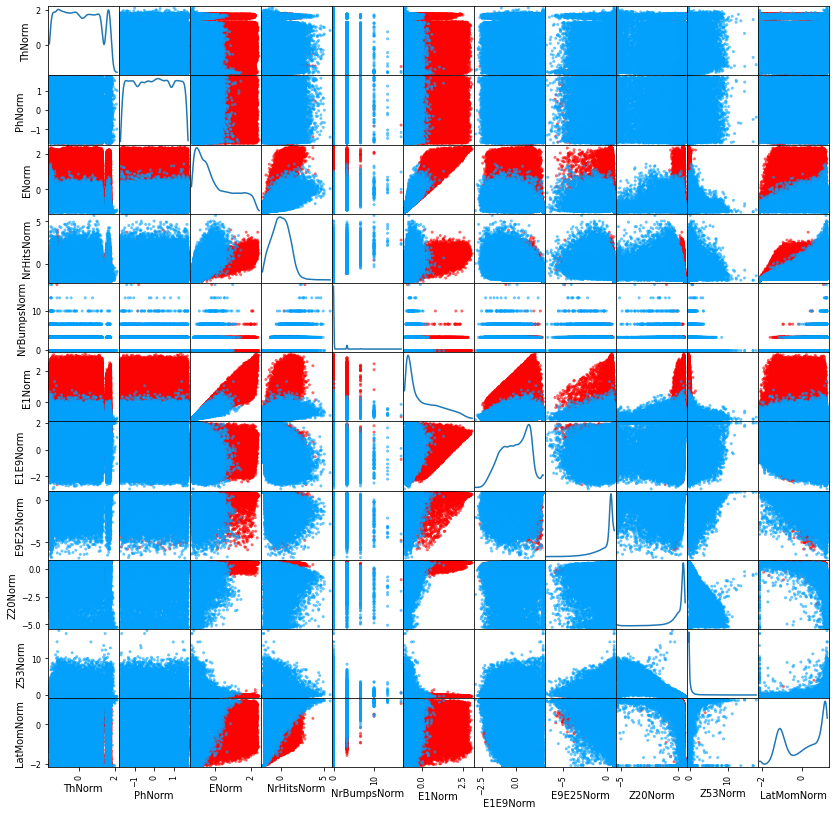

In [7]:
# plot scatter matrix for normalised data
colors = ['#fc0303', '#03a1fc']
_ = pd.plotting.scatter_matrix(data[featuresNorm], figsize=(14,14), diagonal='kde', alpha=0.6, color=[colors[x-1] for x in list(data.id)])

Based on the scatter matrix, the following features appear best separate neutrons and photons:


*   E
*   E1
*   Ph
*   Th 
*   NrHits

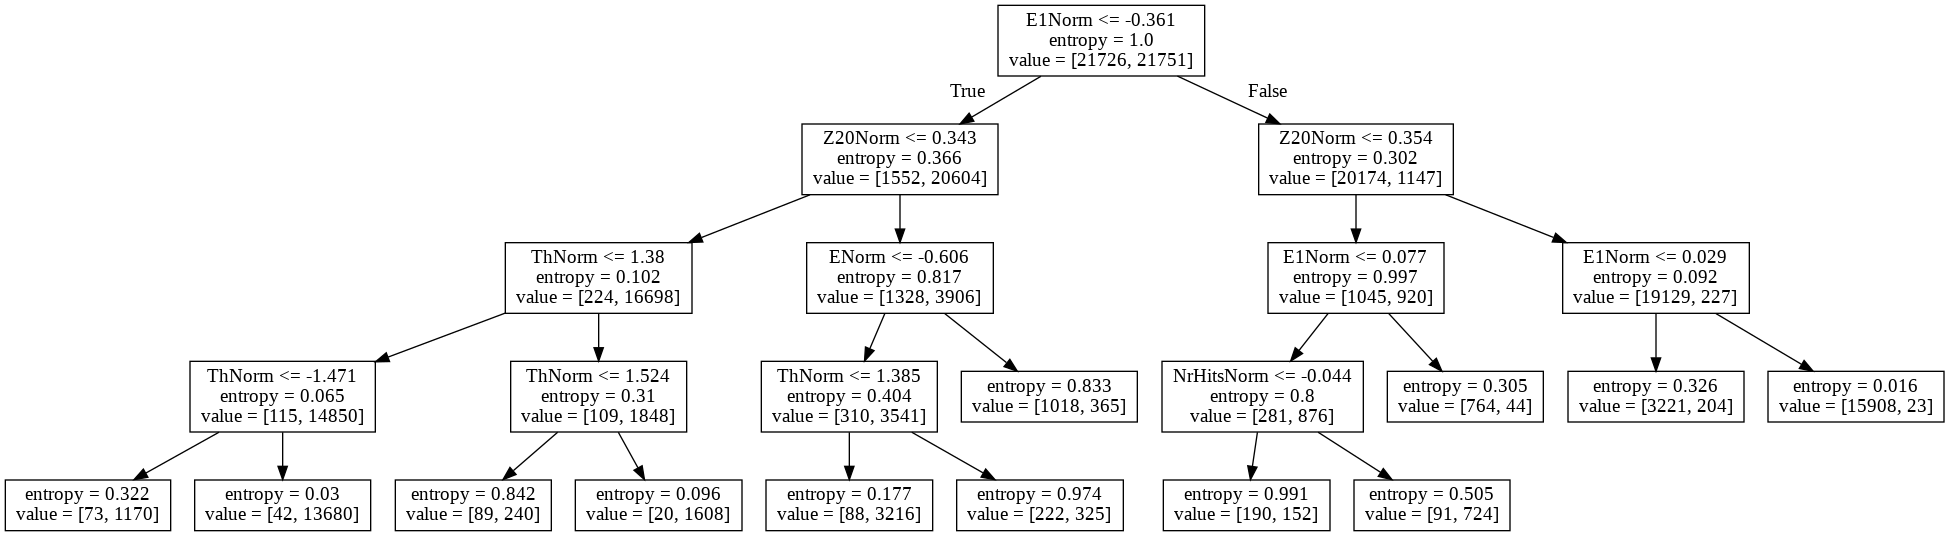

In [8]:
# using the decision tree to determine best features to use
min_impurity_decrease = 0.003
max_depth             = None
params                = [min_impurity_decrease, max_depth]

dataDT = classifySupervised(classifier="DT", data=data, params=params, featureList=featuresNorm, plotTree=True)

Based on the decision tree, the following features appear to best separate neutrons and photons:


*   E1
*   Z20
*   E
*   Th

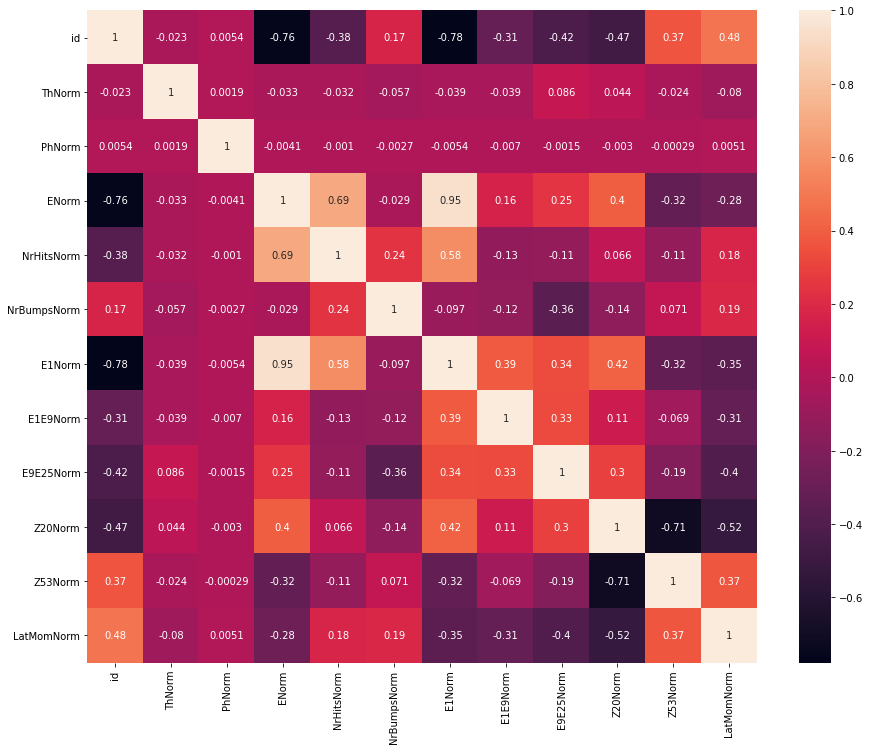

In [9]:
# correlation matrix

corrMatrix = data[np.concatenate((['id'], featuresNorm))].corr()

plt.figure(figsize=(15, 12))
sn.heatmap(corrMatrix, annot=True)
plt.show()

In the correlation matrix it is a bit less apparant what the best choices seem to be. First we look at the correlation values with the id, if this is a high value then the features changes a lot when the id changes and hence it is a good explanatory value. These seem to be:


*   E1
*   E
*   Z20
*   LatMom

Then we look at the correlation in between two features, if this is high then they explain the data in the same way. If this is the case, we can omit one of these features, because their explanatory value is similar. Features with high correlation are:
*   E1 and E
*   Z20 and Z53
*   E and NrHits



**The Significant Features**

Using our knowledge from the scatter matrix, the decision tree and the correlation matrix, we chose the features E1, Z20, Th, LatMom. In the decision tree we see E1 has the highest entropy of all features, hence it is a logical choice. We then don't chose E because they are correlated. Then Z20 jumped out from the decision tree and the correlation matrix and also isn't that correlated with E1. Th looked good in the scatter matrix and also appeared in the decision tree, in the correlation matrix we see it has a very low correlation with all other features, which is good. Then as last we chose LatMom, it has a high correlation with the id, also in the scatter matrix in combination with E1 it looks like it seperates the photons and neutrons nicely.

In [10]:
# list of significant features to be used in machine learning
featuresSig = ['E1Norm', 'Z20Norm', 'ThNorm', 'LatMomNorm']

**Determining the success of a ML Classifier:** \\
The success of a ML Classifier will be determined by calculating the FOM of the results. The best case scenario for the FOM would be when S is a maximum (i.e. all photons are selected) and when B is zero. For the entire set of data this value is 208.23

In [11]:
# function to calculate FOM
def calcFOM (data, testOnly = False):
  '''
  Function that calculates the FOM for 'data'. 'testOnly' determines whether the FOM should be calculated for all of the data or only the test data.

  Returns a tuple where the first value is the FOM and the second value is the best case scenario for the FOM (S=max and B=0).
  '''

  if testOnly:
    # total number of actual photons in test data
    maxS = len(data[(~data['isTrain']) & (data['id'] == 1)])

    # remove all background (neutrons) based on predictions in test data
    dataTemp = data[(~data['isTrain']) & (data['prediction'] == 1)].copy()
  else:
    # total number of actual photons in data
    maxS = len(data[(data['id'] == 1)])

    # remove all background (neutrons) based on predictions in data
    dataTemp = data[(data['prediction'] == 1)].copy()

  S = len(dataTemp[dataTemp.id == 1])
  B = len(dataTemp[dataTemp.id == 2])

  FOM = S / np.sqrt(S + B)
  FOMMax = np.sqrt(maxS)

  return FOM, FOMMax


**Implementing the Classifier Method:** \\
Using the classifier method with manually selected parameters for each and outputting a summary of the results -> how much of the data was correctly classified and the FOM value. 

**Using the kNN classifier:**

In [12]:
dataKNN = classifySupervised("kNN", data, [20], featureList=featuresSig)

In [13]:
trainC = len(dataKNN[(dataKNN['isTrain']) & (dataKNN['prediction'] == dataKNN['id'])])
trainW = len(dataKNN[(dataKNN['isTrain']) & (dataKNN['prediction'] != dataKNN['id'])])
testC = len(dataKNN[(~dataKNN['isTrain']) & (dataKNN['prediction'] == dataKNN['id'])])
testW = len(dataKNN[(~dataKNN['isTrain']) & (dataKNN['prediction'] != dataKNN['id'])])
testFOM = np.round(calcFOM(dataKNN, True),2)
totalFOM = np.round(calcFOM(dataKNN, False),2)

print('Training Data:')
print(f'- Correct: \t{trainC}')
print(f'- Incorrect: \t{trainW}')

print('\nTest Data:')
print(f'- Correct: \t{testC}')
print(f'- Incorrect: \t{testW}')
print(f'- FOM: \t\t{testFOM[0]} \t(Max: {testFOM[1]})')

print('\nTotal Data:')
print(f'- Correct: \t{trainC+testC}')
print(f'- Incorrect: \t{trainW+testW}')
print(f'- FOM: \t\t{totalFOM[0]} \t(Max: {totalFOM[1]})')

Training Data:
- Correct: 	42028
- Incorrect: 	1229

Test Data:
- Correct: 	42324
- Incorrect: 	1291
- FOM: 		142.95 	(Max: 147.31)

Total Data:
- Correct: 	84352
- Incorrect: 	2520
- FOM: 		202.2 	(Max: 208.23)


**Using Random Forest Classifier:**

In [14]:
dataRF = classifySupervised("RF", data, [100, 'auto'], featureList=featuresSig)

In [15]:
trainC = len(dataRF[(dataRF['isTrain']) & (dataRF['prediction'] == dataRF['id'])])
trainW = len(dataRF[(dataRF['isTrain']) & (dataRF['prediction'] != dataRF['id'])])
testC = len(dataRF[(~dataRF['isTrain']) & (dataRF['prediction'] == dataRF['id'])])
testW = len(dataRF[(~dataRF['isTrain']) & (dataRF['prediction'] != dataRF['id'])])
testFOM = np.round(calcFOM(dataRF, True),2)
totalFOM = np.round(calcFOM(dataRF, False),2)

print('Training Data:')
print(f'- Correct: \t{trainC}')
print(f'- Incorrect: \t{trainW}')

print('\nTest Data:')
print(f'- Correct: \t{testC}')
print(f'- Incorrect: \t{testW}')
print(f'- FOM: \t\t{testFOM[0]} \t(Max: {testFOM[1]})')

print('\nTotal Data:')
print(f'- Correct: \t{trainC+testC}')
print(f'- Incorrect: \t{trainW+testW}')
print(f'- FOM: \t\t{totalFOM[0]} \t(Max: {totalFOM[1]})')

Training Data:
- Correct: 	43384
- Incorrect: 	2

Test Data:
- Correct: 	42288
- Incorrect: 	1198
- FOM: 		143.3 	(Max: 147.36)

Total Data:
- Correct: 	85672
- Incorrect: 	1200
- FOM: 		205.35 	(Max: 208.23)


**Using Multi-layer Perceptron Neural Learning:**

In [16]:
dataMLP = classifySupervised("MLP", data, [(5,)], featureList=featuresSig)

In [17]:
trainC = len(dataMLP[(dataMLP['isTrain']) & (dataMLP['prediction'] == dataMLP['id'])])
trainW = len(dataMLP[(dataMLP['isTrain']) & (dataMLP['prediction'] != dataMLP['id'])])
testC = len(dataMLP[(~dataMLP['isTrain']) & (dataMLP['prediction'] == dataMLP['id'])])
testW = len(dataMLP[(~dataMLP['isTrain']) & (dataMLP['prediction'] != dataMLP['id'])])
testFOM = np.round(calcFOM(dataMLP, True),2)
totalFOM = np.round(calcFOM(dataMLP, False),2)

print('Training Data:')
print(f'- Correct: \t{trainC}')
print(f'- Incorrect: \t{trainW}')

print('\nTest Data:')
print(f'- Correct: \t{testC}')
print(f'- Incorrect: \t{testW}')
print(f'- FOM: \t\t{testFOM[0]} \t(Max: {testFOM[1]})')

print('\nTotal Data:')
print(f'- Correct: \t{trainC+testC}')
print(f'- Incorrect: \t{trainW+testW}')
print(f'- FOM: \t\t{totalFOM[0]} \t(Max: {totalFOM[1]})')

Training Data:
- Correct: 	42031
- Incorrect: 	1540

Test Data:
- Correct: 	41730
- Incorrect: 	1571
- FOM: 		142.21 	(Max: 147.56)

Total Data:
- Correct: 	83761
- Incorrect: 	3111
- FOM: 		200.72 	(Max: 208.23)


**Best suited classifier**

kNN works best because it allows for non-linear dependence of the optimal features and follows a clear and easy to understand algorithm. Our data size is sufficiently large to use it without losing density places of information.


**Finding the optimum value of k**

In [18]:
# Piece of code that performs cross validation for kNN classifier(adapted from 20201014_JGM_CMST.ipynb by J.G. Messchendorp)
def kNN_test(k,reps,data=data,testDataOnly=True):
    """ 
    Function that performs a kNN classification for "reps" cross validations. It returns the FOM for the
    test data.
    """
    
    total_result = []
        
    for rep in range(reps):
      
        dk =classifySupervised("kNN", data, params=[k], featureList=featuresSig)
        
        FOM_total =  calcFOM(dk, testDataOnly)[0]        
        total_result.append(FOM_total)

    return [total_result]

# code to find maximum value in an array
def findMax(domain, results, plot = False):
  ''' 
  Find the maximum value in 'results' and corresponding value in 'domain'. 
  plot = True: Plots all the values to visualise the maximum. 
  '''

  max = 0
  x = -1

  # find largest value in results
  for i, val in enumerate(results):
    if val > max:
      max = val 
      x = domain[i]

  # if plot is selected plot all the data values
  if (plot):
    plt.plot(domain,results,label='FOM')
    plt.plot(x, max, 'o', label='Maximum')
    plt.xlabel('k')
    plt.ylabel('FOM')
    plt.legend(loc='best')

    plt.show()

  return (x, max)

In [19]:
# since running the kNN_test is very resource intensive process, we will start by checking a large range (with large intervals)
# and then we will refine the range to find a more precise k value

# the FOM will be calculated for the test data

In [20]:
# this value decides how many times the data is fitted
# a larger number means that there is less statistical error however it takes make longer to run
# please reduce this number if the code below is taking too long to run
nrReps = 5 

In [21]:
# starting list for kValues and results
kList1 = np.arange(1, 202, 20)
results1 = []

# calculate FOM for all k values (average over 10 reps)
for k in kList1:
  res = kNN_test(k, nrReps, data)
  avgFOM = np.mean(res)
  results1.append(avgFOM)

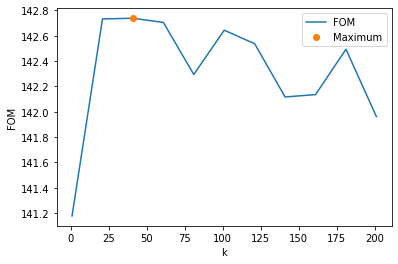

k = 41, FOM = 142.73813829282005


In [22]:
k1Max, res1Max = findMax(kList1, results1, True)
print(f'k = {k1Max}, FOM = {res1Max}')

In [ ]:
# create a new list for a smaller range of k based on the previous results
if (k1Max == 1):
  kList2 = np.arange(k1Max, k1Max + 20, 1)
else:
  kList2 = np.arange(k1Max - 10, k1Max + 10, 1)

results2 = []

# calculate FOM for all k values (average over 10 reps)
for k in kList2:
  res = kNN_test(k, nrReps, data)
  avgFOM = np.mean(res)
  results2.append(avgFOM)

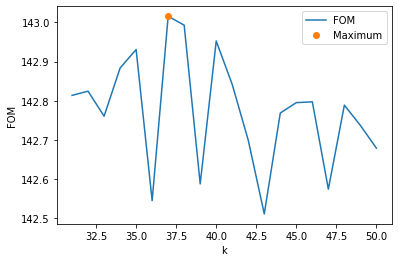

k = 37, FOM = 143.015752601495


In [24]:
k2Max, res2Max = findMax(kList2, results2, True)
print(f'k = {k2Max}, FOM = {res2Max}')

**Effect of over and under fitting:**

In [25]:
#over fitting the data would mean choosing a small value of k
overfit = kNN_test(1, 10, data)
avgOF = np.mean(overfit)
print(f"The FOM for k=1, taken as an average from 10 cross validations is {avgOF:.2f}")

The FOM for k=1, taken as an average from 10 cross validations is 141.29


In [26]:
#under fitting the data ==> choosing a large k
underfit = kNN_test(200, 10, data)
avgUF = np.mean(underfit)
print(f"The FOM for k=200, taken as an average from 10 cross validations is {avgUF:.2f}")

The FOM for k=200, taken as an average from 10 cross validations is 142.11


From the values above it is evident that the FOM is much smaller for very small and very large values of k, hence they are not optimal parameters to fit the data.

**Finding signal probability for maximum FOM**

In [27]:
def knn_prob(reps, data=data, k=k2Max):
  '''
  Returns the optimal signal probability for a sample in the test data to identify as a photon. It uses the k value obtained above for maximum FOM.
  '''

  med = []                  #list to store optimal signal probabilities of 'reps' crossover test samples 
  p_list = np.arange(0.1,1,0.1)       #values of signal probabilities to choose from
  for rep in range(reps):

    datak =classifySupervised("kNN", data, params=[k2Max], featureList=featuresSig)
    X_test = datak[(~datak['isTrain'])][featuresSig]    #testing data
    X_train = datak[(datak['isTrain'])][featuresSig]    #training data
    y_train = datak[(datak['isTrain'])]['id']           #label of training data
    y_label = datak[(~datak['isTrain'])]['id']          #true label of testing data

    knn = neighbors.KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    prob = knn.predict_proba(X_test)[:,0] #probability the instance is a photon

    #true number of photons in test sample
    a=0
    for h in range(len(y_label.values)):
      if y_label.values[h]==1:
        a +=1                     

    S=[]                  #list to store diff of labelled photons and actual number of photons for different signal probabilities
    for p_l in p_list:      #loop over values of sig prob
      sig = 0               #number of labelled photons
      for p in (prob):
        if p>p_l:                   #condition for instance to be predicted as photon
          sig+=1 
      S.append(abs(sig-a))       #difference b/w labelled photons and actual number of photons
    d = S.index(min(S))          #index of best estimated photon number
    med.append(p_list[d])        #optimal sig prob value for 1 rep
  return np.mean(med)            #optimal sig prob value over 'reps' crossovers

In [28]:
#optimal sig prob for 5 crossovers
print('The signal probability for maximim FOM is',knn_prob(5))

The signal probability for maximim FOM is 0.5


**Varying the input features:**

In [29]:
def kNN_FOM(features, data=data,testDataOnly=True):
    """ 
    Returns FOM for test data of kNN classifier conducted with given features and optimized parameter.
    """

    dk = classifySupervised("kNN", data, params=[20], featureList=features) 
    FOM_total =  calcFOM(dk, testDataOnly)[0]      

    return FOM_total
  
# calculating the FOM of kNN with the previously chosen features 
# ('E1Norm', 'Z20Norm', 'ThNorm', 'LatMomNorm')
chosen_features_FOM = kNN_FOM(featuresSig)

In [30]:
# first we're going to look at the features individually and see which ones have a larger FOM, i.e. which ones are individually more powerful
FOMforeachfeature = []
for i in range(11):
  FOM = kNN_FOM([featuresNorm[i]])
  FOMforeachfeature.append(FOM)

  print(i, featuresNorm[i], FOM)

0 ThNorm 81.61354861965107
1 PhNorm 80.19340586962564
2 ENorm 128.67953422935418
3 NrHitsNorm 106.29533935400605
4 NrBumpsNorm 105.13482453301359
5 E1Norm 137.27996785772356
6 E1E9Norm 97.56628539493849
7 E9E25Norm 126.89231491759276
8 Z20Norm 131.54600788839696
9 Z53Norm 127.9965077947644
10 LatMomNorm 109.85618557635631


In [31]:
# from these we're excluding anything with FOM < 110
opt_features = []
for i in FOMforeachfeature:
    if i >= 110:
        opt_features.append(featuresNorm[FOMforeachfeature.index(i)])
        
# loop creates a list of every single combination that can be made with the chosen
feature_combos = []
choices = opt_features
for i in range(len(opt_features)):
    for option in cmb(opt_features, i+1):
        feature_combos.append(option)

# converting each list entry from a tuple to a list to make it usable for the above functions
for i in range(len(feature_combos)):
    feature_combos[i] = list(feature_combos[i])


# gives the FOM of the kNN with the different optimized feature combinations
FOM_results = []
for i in feature_combos:
    FOM_results.append(kNN_FOM(i))

In [32]:
# we find the combinations that gave a FOM larger than or equal to the one we had previously
combosSig = []
for i in FOM_results:
  if i >= chosen_features_FOM:
    combosSig.append(i) 

print('FOM Results', '\t\t', 'Combination of features used')
for i in combosSig:
  print(FOM_results[FOM_results.index(i)], '\t', feature_combos[FOM_results.index(i)])

print('Original combination and FOM','\n' ,chosen_features_FOM, '\t', featuresSig)

FOM Results 		 Combination of features used
142.59869387065515 	 ['ENorm', 'E1Norm', 'Z20Norm']
142.90390617706527 	 ['E1Norm', 'E9E25Norm', 'Z20Norm']
142.75569265797964 	 ['E1Norm', 'Z20Norm', 'Z53Norm']
143.1156228128729 	 ['ENorm', 'E1Norm', 'Z20Norm', 'Z53Norm']
142.32910215944437 	 ['ENorm', 'E9E25Norm', 'Z20Norm', 'Z53Norm']
142.45596093662374 	 ['E1Norm', 'E9E25Norm', 'Z20Norm', 'Z53Norm']
142.82591854297655 	 ['ENorm', 'E1Norm', 'E9E25Norm', 'Z20Norm', 'Z53Norm']
Original combination and FOM 
 142.3068798439821 	 ['E1Norm', 'Z20Norm', 'ThNorm', 'LatMomNorm']


**Discussion**

From the obtained results we see that the combination of features that we used in the main part of the project is not included although 3 out of 4 of the features are used in other ones. Z53 was found to be a prominent feature on the correlation matrix but was excluded from the list used. 

The strongest features according to the classifier therefore are E, E1, Z20, Z53, E9E25 and the the redundant ones being the rest.

We also see that the combination with the largest FOM is 3 features long, which is longer than our previoius combination. This means that those features together were more effective at classifying photons and neutrons. This is also reflected in the scatter matrix as those graphs have a higher visual division of photon and neutron dots. 

Obviously the above process can also be done skipping the first step and using all 11 features and running through each combination of those, but unfortunately that would be very resource heavy and the ETA for running that cell wouldve been ~2 hours or more. 
Despite this after some brief testing, we found out that including a lower FOM feature on a combination of features didn't necessarily raise the FOM value for the entire combination and even brought it down in some cases. Therefore the obtained results are overall representative of the optimal combination of features. 